# Chess Game Result Predictor

## Step 1: Load the Data

In [5]:
import pandas as pd
data = pd.read_csv('games.csv')

In [7]:
data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Step 2: Clean the Data

Lets start off by eliminating the games that ended abruptly due to one player being unable to play. Lets check the games that ended without a mate before 10 moves. If they seem irrelevant, we will remove them from our data. One player leaving without a reason is unpredictable and holds no value for models.

In [9]:
early_non_mate_games_10 = data[(data['turns'] <= 10) & (data['victory_status'] != 'mate')]

In [11]:
early_non_mate_games_10.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
5,MsoDV9wj,False,1.504240e+12,1.504240e+12,5,draw,draw,10+0,trelynn17,1250,franklin14532,1002,e4 c5 Nf3 Qa5 a3,B27,Sicilian Defense: Mongoose Variation,4
7,RVN0N3VK,False,1.503680e+12,1.503680e+12,9,resign,black,15+30,daniel_likes_chess,1413,soultego,2108,e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4,B00,Nimzowitsch Defense: Kennedy Variation | Link...,5
21,QFCZwY1f,False,1.502950e+12,1.502950e+12,3,resign,white,30+60,shivangithegenius,1094,themannichreaction,1068,d4 e6 Nc3,A40,Horwitz Defense,2
46,27zreJYy,False,1.499330e+12,1.499330e+12,3,resign,black,15+0,shivangithegenius,978,jjwrchess,1500,e4 d5 exd5,B01,Scandinavian Defense,2
47,IRYkgI8N,False,1.499320e+12,1.499320e+12,7,resign,white,10+0,adnanraj,1343,shivangithegenius,978,e4 c5 Bc4 Nf6 e5 Ne4 Nf3,B20,Sicilian Defense: Bowdler Attack,3


I now realized that people blundering their queen and resign at something like move 5 is not something predictable by a ML model. Well not predictable to humans as well. Including those data would only confuse the model. It is best to take all games into account if it ended with mate, and take into account that games didn't end with a mate but lasted longer than 20 moves. 20 moves is a good threshold because we are out of the opening phase and mid-game tactics and strategic plans are more evident. Lets filter the data and see how many relevant data we have.

In [13]:
filtered_data = data[(data['victory_status'] == 'mate') | (data['turns'] > 20)]

In [15]:
print(f"Number of games after filtering: {len(filtered_data)}")

Number of games after filtering: 18576


In [12]:
filtered_data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
6,qwU9rasv,True,1.504230e+12,1.504230e+12,33,resign,white,10+0,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10
8,dwF3DJHO,True,1.503510e+12,1.503510e+12,66,resign,black,15+0,ehabfanri,1439,daniel_likes_chess,1392,e4 e5 Bc4 Nc6 Nf3 Nd4 d3 Nxf3+ Qxf3 Nf6 h3 Bc5...,C50,Italian Game: Schilling-Kostic Gambit,6


Let's remove the unnecessary features such as white_id, black_id, id, created_at, last_move_at. We will talk about other features that might not be that useful as well, but these are the ones that we are 100% sure won't be helpful for our training.

In [14]:
filtered_data = filtered_data.drop(columns=['id', 'white_id', 'black_id', 'created_at', 'last_move_at'])

In [15]:
filtered_data

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
2,True,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
6,True,33,resign,white,10+0,1520,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10
8,True,66,resign,black,15+0,1439,1392,e4 e5 Bc4 Nc6 Nf3 Nd4 d3 Nxf3+ Qxf3 Nf6 h3 Bc5...,C50,Italian Game: Schilling-Kostic Gambit,6
...,...,...,...,...,...,...,...,...,...,...,...
20053,True,24,resign,white,10+10,1691,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,True,82,mate,black,10+0,1233,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,True,35,mate,white,10+0,1219,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,True,109,resign,white,10+0,1360,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


For more feature removal, it's advisable to eliminate one of the opening_name or opening_eco columns, as they represent the same information. ECO stands for "Encyclopaedia of Chess Openings," and opening_name provides the corresponding opening name. I prefer to retain opening_eco since it is already in an encoded format, making it more efficient for our model.

We can also remove the moves column because analyzing individual moves is highly complex, and our aim is not to replicate a chess engine like Stockfish. Additionally, including the moves column could allow us to indirectly determine the winner by evaluating game patterns, which would stray from our goal of predicting results based on general player and game information.

Lastly, the increment_code column does not provide meaningful insight into the outcome of the game, so it will also be removed.

Finally, the opening_ply column, which represents the number of moves in the opening phase, does not add meaningful information for predicting the game result. Since we do not know who effectively broke out of the opening phase, it becomes irrelevant for our purpose

In [17]:
filtered_data = filtered_data.drop(columns=['opening_name', 'moves', 'increment_code', 'opening_ply'])

In [18]:
filtered_data

,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco
2,True,61,mate,white,1496,1500,C20
3,True,61,mate,white,1439,1454,D02
4,True,95,mate,white,1523,1469,C41
6,True,33,resign,white,1520,1423,D00
8,True,66,resign,black,1439,1392,C50
...,...,...,...,...,...,...,...
20053,True,24,resign,white,1691,1220,A80
20054,True,82,mate,black,1233,1196,A41
20055,True,35,mate,white,1219,1286,D00
20056,True,109,resign,white,1360,1227,B07


Let's remove the duplicate rows.

In [20]:
filtered_data = filtered_data.drop_duplicates()

This is how our data looks right now:

In [22]:
filtered_data

,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco
2,True,61,mate,white,1496,1500,C20
3,True,61,mate,white,1439,1454,D02
4,True,95,mate,white,1523,1469,C41
6,True,33,resign,white,1520,1423,D00
8,True,66,resign,black,1439,1392,C50
...,...,...,...,...,...,...,...
20053,True,24,resign,white,1691,1220,A80
20054,True,82,mate,black,1233,1196,A41
20055,True,35,mate,white,1219,1286,D00
20056,True,109,resign,white,1360,1227,B07


We started off with 20,058 rows and we now have 17,712 after the cleaning. We also removed the unnecessary features. This makes the end of our Data Cleaning.

## Step 3: Exploratory Data Analysis (EDA)

In [25]:
filtered_data.describe()

,turns,white_rating,black_rating
count,17712.000000,17712.000000,17712.000000
mean,64.392841,1606.007565,1599.840334
std,31.651284,286.499440,288.121730
min,4.000000,784.000000,789.000000
25%,41.000000,1413.000000,1405.000000
50%,58.000000,1577.000000,1572.000000
75%,81.000000,1800.000000,1796.000000
max,349.000000,2622.000000,2621.000000


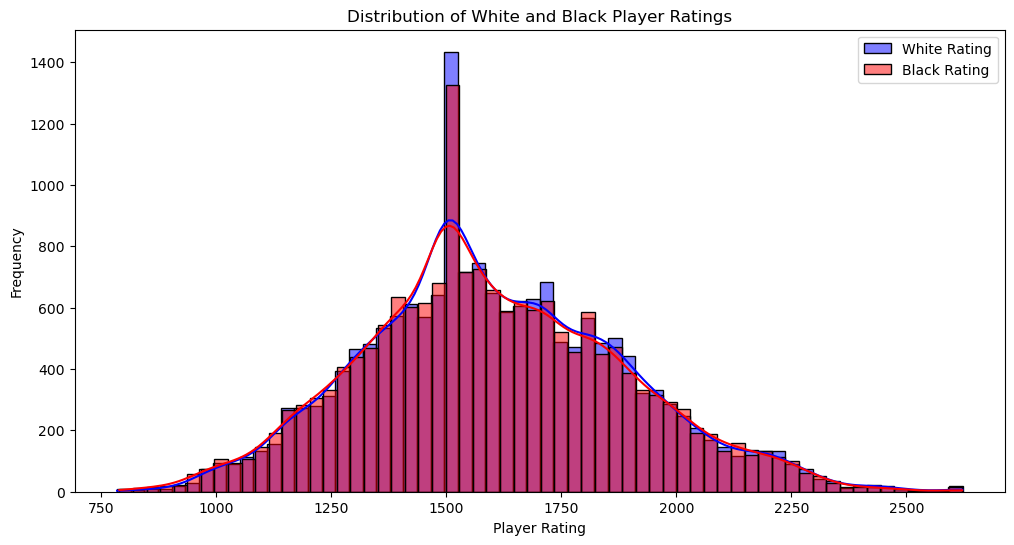

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['white_rating'], kde=True, color='blue', label='White Rating')
sns.histplot(filtered_data['black_rating'], kde=True, color='red', label='Black Rating')
plt.xlabel('Player Rating')
plt.ylabel('Frequency')
plt.title('Distribution of White and Black Player Ratings')
plt.legend()
plt.show()

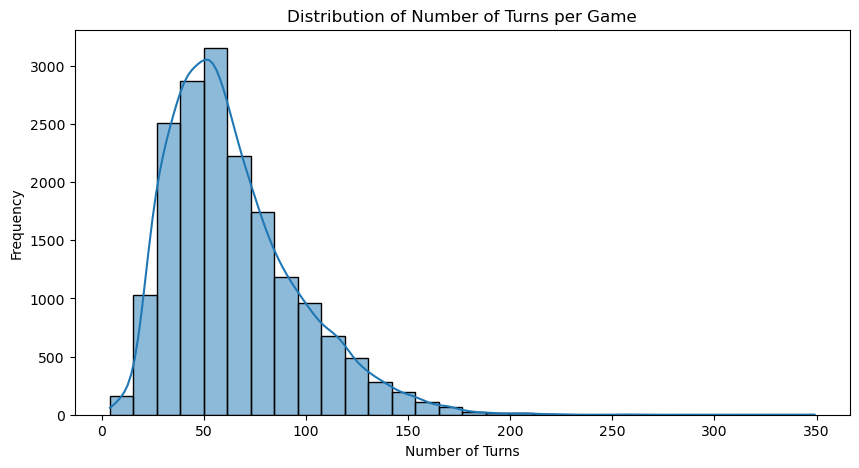

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(filtered_data['turns'], kde=True, bins=30)
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Turns per Game')
plt.show()

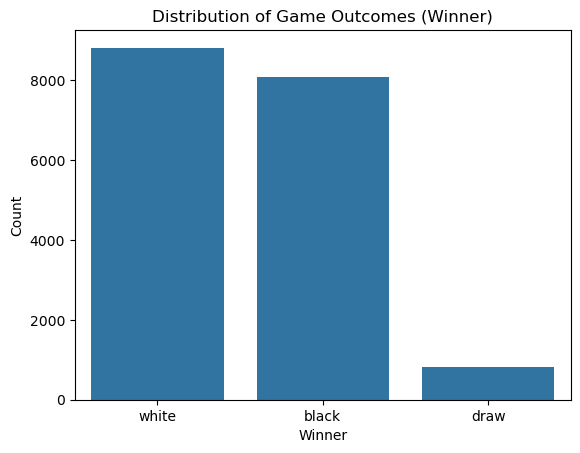

In [28]:
sns.countplot(x='winner', data=filtered_data)
plt.title('Distribution of Game Outcomes (Winner)')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

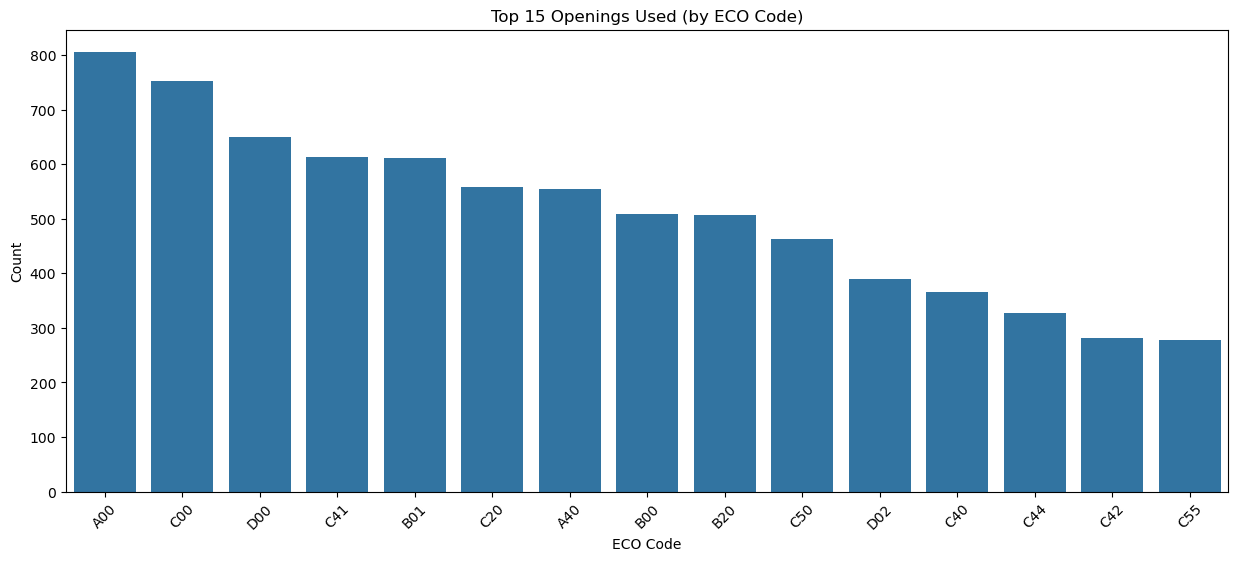

In [29]:
plt.figure(figsize=(15, 6))
sns.countplot(x='opening_eco', data=filtered_data, order=filtered_data['opening_eco'].value_counts().index[:15])
plt.title('Top 15 Openings Used (by ECO Code)')
plt.xlabel('ECO Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

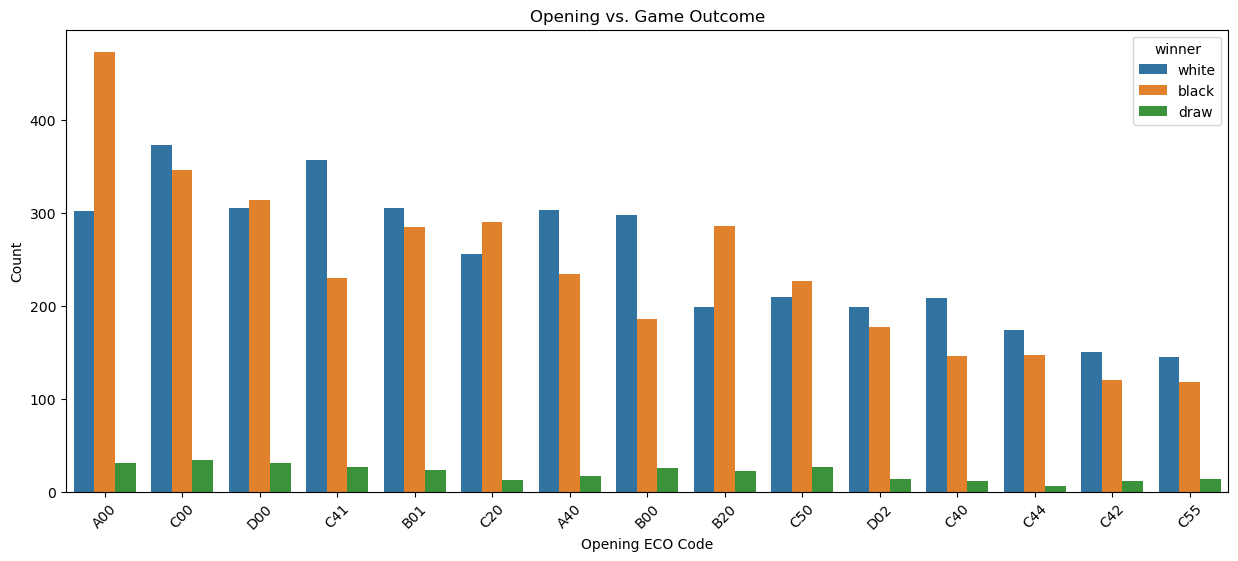

In [30]:
plt.figure(figsize=(15, 6))
sns.countplot(x='opening_eco', hue='winner', data=filtered_data, order=filtered_data['opening_eco'].value_counts().index[:15])
plt.title('Opening vs. Game Outcome')
plt.xlabel('Opening ECO Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Let's create a new feature called rating_difference, because the difference between ratings could give us hints about the game result.

In [32]:
filtered_data = filtered_data.copy()
filtered_data['rating_difference'] = filtered_data['white_rating'] - filtered_data['black_rating']

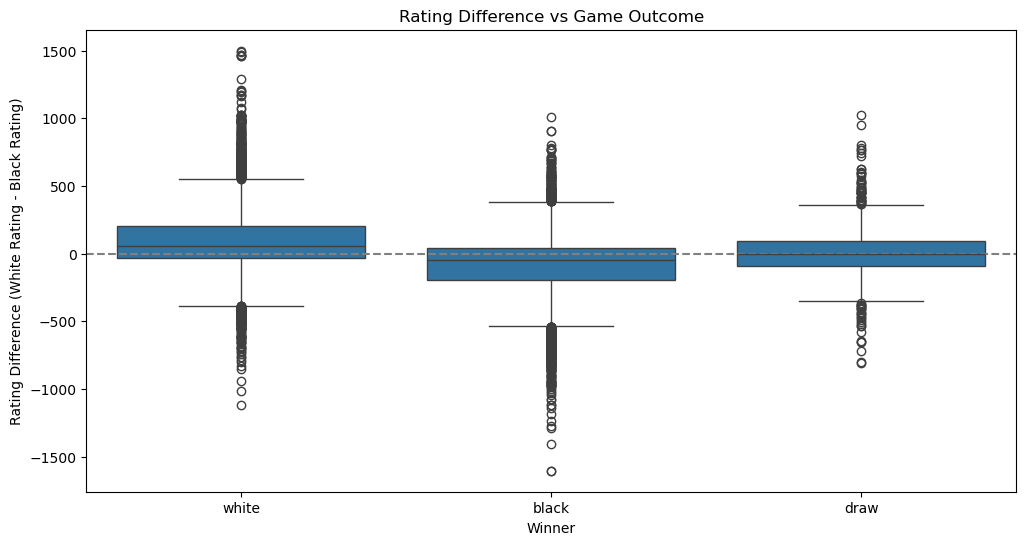

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='winner', y='rating_difference', data=filtered_data)
plt.title('Rating Difference vs Game Outcome')
plt.xlabel('Winner')
plt.ylabel('Rating Difference (White Rating - Black Rating)')
plt.axhline(0, color='gray', linestyle='--')  # Line to indicate equal rating
plt.show()

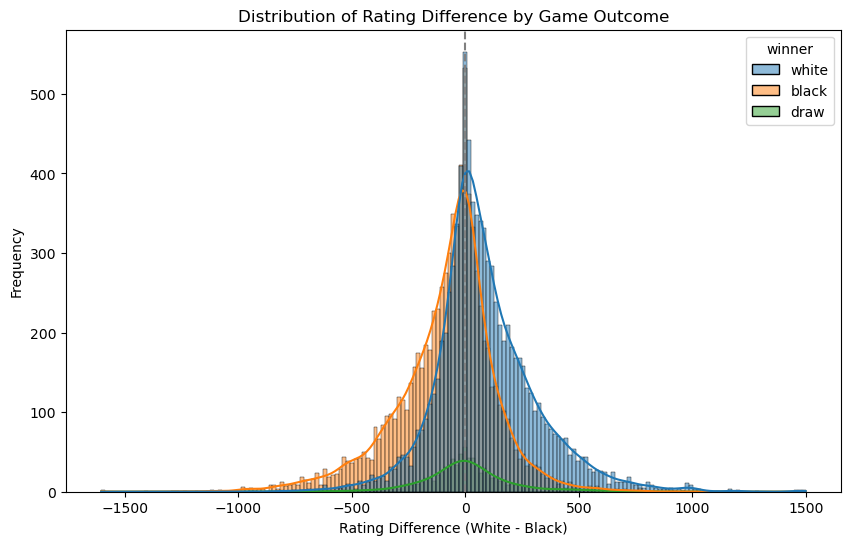

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data, x='rating_difference', hue='winner', kde=True)
plt.title('Distribution of Rating Difference by Game Outcome')
plt.xlabel('Rating Difference (White - Black)')
plt.ylabel('Frequency')
plt.axvline(0, color='gray', linestyle='--')  # Line to indicate equal rating
plt.show()

## Step 4: Preprocess the Data

In [36]:
filtered_data['rated'] = filtered_data['rated'].astype(int)
filtered_data_encoded = pd.get_dummies(filtered_data, columns=['victory_status'])
winner_mapping = {'white': 1, 'black': -1, 'draw': 0}
filtered_data_encoded['winner_numeric'] = filtered_data_encoded['winner'].map(winner_mapping)
filtered_data_encoded = filtered_data_encoded.drop(columns=['winner'])
filtered_data_encoded = filtered_data_encoded.rename(columns={'winner_numeric': 'winner'})
filtered_data_encoded.head()

,rated,turns,white_rating,black_rating,opening_eco,rating_difference,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,winner
2,1,61,1496,1500,C20,-4,False,True,False,False,1
3,1,61,1439,1454,D02,-15,False,True,False,False,1
4,1,95,1523,1469,C41,54,False,True,False,False,1
6,1,33,1520,1423,D00,97,False,False,False,True,1
8,1,66,1439,1392,C50,47,False,False,False,True,-1


For the opening_eco, we need to encode because there are too many unique values there and having them all as booleans would make 300+ features, which could lead to curse of dimensionality in some models. Using the target encoding seem to make the most sense because there is a correlation between opening eco and the game result.

In [38]:
opening_eco_target_mean = filtered_data_encoded.groupby('opening_eco')['winner'].transform('mean')
filtered_data_encoded['opening_eco_encoded'] = opening_eco_target_mean
filtered_data_encoded = filtered_data_encoded.drop(columns=['opening_eco'])
filtered_data_encoded = filtered_data_encoded.rename(columns={'opening_eco_encoded': 'opening_eco'})
filtered_data_encoded.head()

,rated,turns,white_rating,black_rating,rating_difference,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,winner,opening_eco
2,1,61,1496,1500,-4,False,True,False,False,1,-0.062724
3,1,61,1439,1454,-15,False,True,False,False,1,0.056410
4,1,95,1523,1469,54,False,True,False,False,1,0.207178
6,1,33,1520,1423,97,False,False,False,True,1,-0.013846
8,1,66,1439,1392,47,False,False,False,True,-1,-0.038961


## Step 5: Split the Data

Here, I decided to split the data into 80% training, 10% validation and 10% testing.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
filtered_data = filtered_data_encoded
X = filtered_data.drop(columns=['winner','victory_status_outoftime','victory_status_draw','victory_status_mate','victory_status_resign'])
y = filtered_data['winner']

In [43]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 14169
Validation set size: 1771
Test set size: 1772


In [44]:
from collections import Counter
class_mapping = {-1: "Black Win", 0: "Draw", 1: "White Win"}
def map_labels(y):
    return [class_mapping[label] for label in y]
print("\nDistribution in Train set:")
print(Counter(map_labels(y_train)))

print("\nDistribution in Validation set:")
print(Counter(map_labels(y_val)))

print("\nDistribution in Test set:")
print(Counter(map_labels(y_test)))


Distribution in Train set:
Counter({'White Win': 7056, 'Black Win': 6475, 'Draw': 638})

Distribution in Validation set:
Counter({'White Win': 883, 'Black Win': 800, 'Draw': 88})

Distribution in Test set:
Counter({'White Win': 876, 'Black Win': 809, 'Draw': 87})


## Train and Evaluate Models

### k-Nearest Neighbors (kNN)

Before we start implementing kNN, we should reduce feature count as much as possible because of the curse of dimensionality. We have black_rating, white_rating and rating_difference features. white_rating and black_rating seem redundant and I believe using rating_difference without them would suffice.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [49]:
features_to_exclude = ['white_rating', 'black_rating']
X_train_knn = X_train.drop(columns=features_to_exclude)
X_val_knn = X_val.drop(columns=features_to_exclude)
X_test_knn = X_test.drop(columns=features_to_exclude)

In [50]:
k_values = list(range(1, 50, 2))
accuracies = []
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_knn, y_train)

    y_val_pred = knn_model.predict(X_val_knn)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append((k, accuracy))
    print(f'Validation Accuracy with kNN (k={k}): {accuracy:.2f}')

Validation Accuracy with kNN (k=1): 0.56
Validation Accuracy with kNN (k=3): 0.55
Validation Accuracy with kNN (k=5): 0.58
Validation Accuracy with kNN (k=7): 0.58
Validation Accuracy with kNN (k=9): 0.58
Validation Accuracy with kNN (k=11): 0.57
Validation Accuracy with kNN (k=13): 0.59
Validation Accuracy with kNN (k=15): 0.59
Validation Accuracy with kNN (k=17): 0.59
Validation Accuracy with kNN (k=19): 0.59
Validation Accuracy with kNN (k=21): 0.58
Validation Accuracy with kNN (k=23): 0.59
Validation Accuracy with kNN (k=25): 0.58
Validation Accuracy with kNN (k=27): 0.59
Validation Accuracy with kNN (k=29): 0.59
Validation Accuracy with kNN (k=31): 0.60
Validation Accuracy with kNN (k=33): 0.60
Validation Accuracy with kNN (k=35): 0.61
Validation Accuracy with kNN (k=37): 0.60
Validation Accuracy with kNN (k=39): 0.60
Validation Accuracy with kNN (k=41): 0.60
Validation Accuracy with kNN (k=43): 0.60
Validation Accuracy with kNN (k=45): 0.60
Validation Accuracy with kNN (k=47): 0.

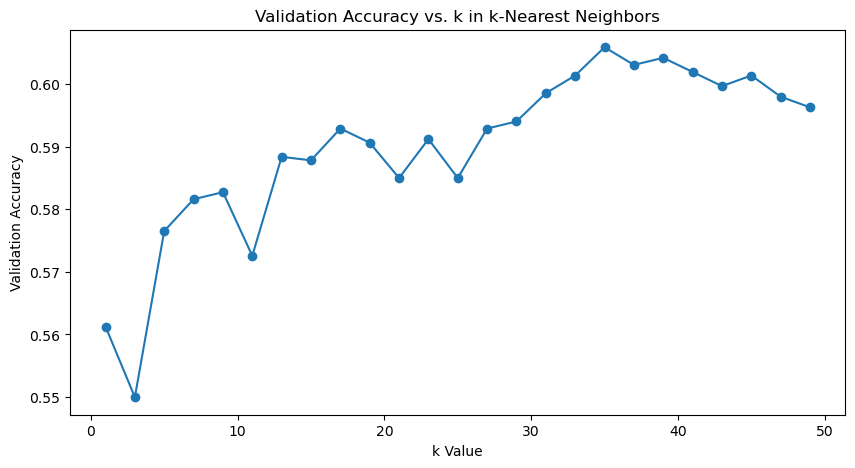

In [51]:
k_list, acc_list = zip(*accuracies)
plt.figure(figsize=(10, 5))
plt.plot(k_list, acc_list, marker='o')
plt.xlabel('k Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. k in k-Nearest Neighbors')
plt.show()

Looks like our kNN accuracy peaks at 61%. I prefer choosing best k as 35 because choosing very high values for kNN is not suggested. Lets move on to the test data and see our results.

In [53]:
best_k = 35

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [55]:
y_test_pred = knn_model.predict(X_test_knn)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy with kNN (k={best_k}): {test_accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'\nPrecision (Macro): {precision:.2f}')
print(f'Recall (Macro): {recall:.2f}')
print(f'F1 Score (Macro): {f1:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['black', 'draw', 'white']))

Test Accuracy with kNN (k=35): 0.59

Confusion Matrix:
[[503   0 306]
 [ 42   0  45]
 [341   0 535]]

Precision (Macro): 0.39
Recall (Macro): 0.41
F1 Score (Macro): 0.40

Classification Report:
              precision    recall  f1-score   support

       black       0.57      0.62      0.59       809
        draw       0.00      0.00      0.00        87
       white       0.60      0.61      0.61       876

    accuracy                           0.59      1772
   macro avg       0.39      0.41      0.40      1772
weighted avg       0.56      0.59      0.57      1772



C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packag

We got warnings because as it turns out, kNN does not predict any draw games. Which could be because games are less likely to be draw, and in our dataset, we see very few games being draw compared to white wins and black wins. Overall, kNN predicts with higher accuracy than random guessing (33%), but the macro-averaged precision, recall, and F1 scores were around 0.39-0.41, which reflects the difficulty of the model in handling the underrepresented classes effectively.

The confusion matrix shows that while the model can predict black and white wins with moderate accuracy, it completely missed the draws. This suggests that further work is needed to handle class imbalance, possibly by employing techniques such as oversampling the draw class, undersampling the majority classes, or using models that can handle class imbalance better.

Overall, while the kNN model provides a baseline performance and demonstrates the ability to capture some game-related patterns, there is room for improvement, especially in addressing class imbalance and exploring more advanced models that could yield better accuracy and balanced predictions across all outcomes.

### kNN with Oversampled Draws

We decided to try out kNN again with oversampled draws to enhance its performance. Undersampling majority classes wouldn't make much sense since we don't have that many draw games so we would need to cut out many other games, and it could deteriorate learning of the model.

In [60]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

print("Class distribution in original training data:")
print(y_train.value_counts())
print("\nClass distribution in resampled training data:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution in original training data:
winner
 1    7056
-1    6475
 0     638
Name: count, dtype: int64

Class distribution in resampled training data:
winner
 1    7056
-1    7056
 0    7056
Name: count, dtype: int64


Now let's split the data into same training-validation-test data and train the kNN with our new resampled data.

Best k value (Resampled and Cleaned Data): 3


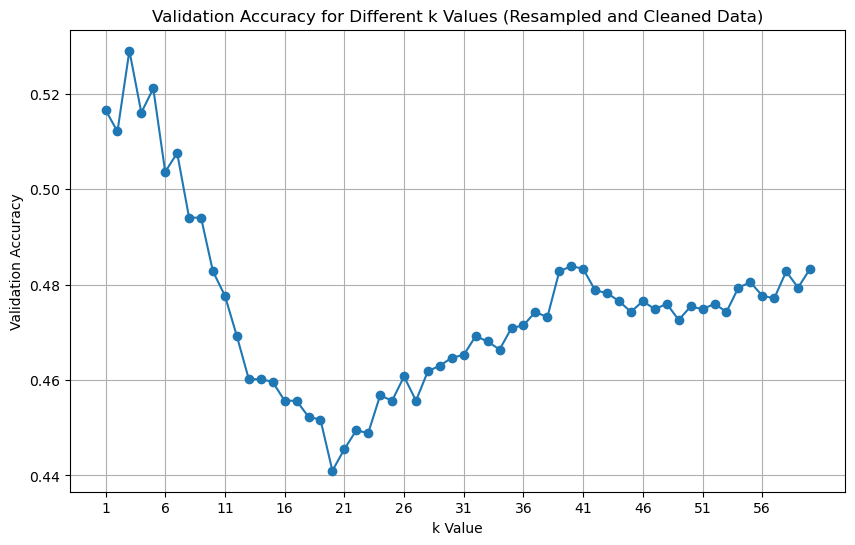

In [62]:
# Perform kNN with resampled and cleaned data
results_resampled_cleaned = []
for k in range(1, 61):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the validation set
    y_val_pred = knn.predict(X_val)
    
    # Calculate validation accuracy
    accuracy_resampled_cleaned = accuracy_score(y_val, y_val_pred)
    results_resampled_cleaned.append((k, accuracy_resampled_cleaned))

# Convert results to a DataFrame
results_resampled_cleaned_df = pd.DataFrame(results_resampled_cleaned, columns=["k", "Validation Accuracy"])

# Find the best k value
best_k_resampled_cleaned = results_resampled_cleaned_df.loc[results_resampled_cleaned_df["Validation Accuracy"].idxmax()]["k"]
print(f"Best k value (Resampled and Cleaned Data): {int(best_k_resampled_cleaned)}")

# Plot validation accuracy for k values
plt.figure(figsize=(10, 6))
plt.plot(results_resampled_cleaned_df["k"], results_resampled_cleaned_df["Validation Accuracy"], marker="o", linestyle="-")
plt.title("Validation Accuracy for Different k Values (Resampled and Cleaned Data)")
plt.xlabel("k Value")
plt.ylabel("Validation Accuracy")
plt.xticks(range(1, 61, 5))  # Show ticks for every 5th k value
plt.grid()
plt.show()

In [63]:
# Train the best kNN model on the cleaned resampled data
best_knn_resampled_cleaned = KNeighborsClassifier(n_neighbors=int(best_k_resampled_cleaned))
best_knn_resampled_cleaned.fit(X_train_resampled, y_train_resampled)

# Test the best kNN model on the cleaned resampled test set
y_test_pred = best_knn_resampled_cleaned.predict(X_test)

# Calculate test accuracy
test_accuracy_resampled_cleaned = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy with kNN (k={best_k_resampled_cleaned}): {test_accuracy_resampled_cleaned:.2f}')

# Confusion Matrix
conf_matrix_resampled_cleaned = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Cleaned Resampled Data):")
print(conf_matrix_resampled_cleaned)

# Precision, Recall, F1 Score
precision_resampled_cleaned = precision_score(y_test, y_test_pred, average='macro')
recall_resampled_cleaned = recall_score(y_test, y_test_pred, average='macro')
f1_resampled_cleaned = f1_score(y_test, y_test_pred, average='macro')

print(f'\nPrecision (Macro, Cleaned Resampled Data): {precision_resampled_cleaned:.2f}')
print(f'Recall (Macro, Cleaned Resampled Data): {recall_resampled_cleaned:.2f}')
print(f'F1 Score (Macro, Cleaned Resampled Data): {f1_resampled_cleaned:.2f}')

# Classification Report
print("\nClassification Report (Cleaned Resampled Data):")
print(classification_report(
    y_test, 
    y_test_pred, 
    target_names=['black', 'draw', 'white']
))

Test Accuracy with kNN (k=3.0): 0.52

Confusion Matrix (Cleaned Resampled Data):
[[442  58 309]
 [ 36  10  41]
 [345  70 461]]

Precision (Macro, Cleaned Resampled Data): 0.39
Recall (Macro, Cleaned Resampled Data): 0.40
F1 Score (Macro, Cleaned Resampled Data): 0.39

Classification Report (Cleaned Resampled Data):
              precision    recall  f1-score   support

       black       0.54      0.55      0.54       809
        draw       0.07      0.11      0.09        87
       white       0.57      0.53      0.55       876

    accuracy                           0.52      1772
   macro avg       0.39      0.40      0.39      1772
weighted avg       0.53      0.52      0.52      1772



Well, it performs worse with oversampling. This means draws are really hard to learn and predict even with more samples.Draws are noisy and just confuses the model. It is best to never use oversampled train data sets because draw count is originally very low anyway. Let's move on to different models.

### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

Scikits logistic regression is supported for multiclass usages. We will use that because we have 3 classes.

In [68]:
logistic_regression = LogisticRegression(
    multi_class='multinomial',  # This is the support provided by scikit for multiclass classification
    solver='lbfgs',            # Solver suitable for multi-class problems
    max_iter=5000,             # Increase iterations to ensure convergence
    random_state=42
)

In [69]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=42)

In [70]:
y_val_pred = logistic_regression.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, y_val_pred))

Validation Report:
              precision    recall  f1-score   support

          -1       0.63      0.59      0.61       800
           0       0.33      0.01      0.02        88
           1       0.64      0.73      0.68       883

    accuracy                           0.63      1771
   macro avg       0.53      0.44      0.44      1771
weighted avg       0.62      0.63      0.61      1771



In [71]:
y_test_pred = logistic_regression.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'\nPrecision (Macro): {precision:.2f}')
print(f'Recall (Macro): {recall:.2f}')
print(f'F1 Score (Macro): {f1:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['black', 'draw', 'white']))

Test Accuracy: 0.61

Confusion Matrix:
[[481   1 327]
 [ 42   1  44]
 [273   0 603]]

Precision (Macro): 0.57
Recall (Macro): 0.43
F1 Score (Macro): 0.42

Classification Report:
              precision    recall  f1-score   support

       black       0.60      0.59      0.60       809
        draw       0.50      0.01      0.02        87
       white       0.62      0.69      0.65       876

    accuracy                           0.61      1772
   macro avg       0.57      0.43      0.42      1772
weighted avg       0.61      0.61      0.60      1772



Didn't perform exceptionally well, but still is better than random guessing a lot. This was expected because of the linear nature of logistic regression. Tried out with different C values etc. but it barely changes anything. Let's move on to other models.

## Random Forest 

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
)

In [76]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
y_val_pred = random_forest.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, y_val_pred))

Validation Report:
              precision    recall  f1-score   support

          -1       0.63      0.63      0.63       800
           0       0.29      0.02      0.04        88
           1       0.65      0.71      0.68       883

    accuracy                           0.64      1771
   macro avg       0.52      0.46      0.45      1771
weighted avg       0.63      0.64      0.63      1771



In [78]:
y_test_pred = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'\nPrecision (Macro): {precision:.2f}')
print(f'Recall (Macro): {recall:.2f}')
print(f'F1 Score (Macro): {f1:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['black', 'draw', 'white']))

Test Accuracy: 0.61

Confusion Matrix:
[[501   5 303]
 [ 46   2  39]
 [289   4 583]]

Precision (Macro): 0.47
Recall (Macro): 0.44
F1 Score (Macro): 0.43

Classification Report:
              precision    recall  f1-score   support

       black       0.60      0.62      0.61       809
        draw       0.18      0.02      0.04        87
       white       0.63      0.67      0.65       876

    accuracy                           0.61      1772
   macro avg       0.47      0.44      0.43      1772
weighted avg       0.59      0.61      0.60      1772



So far all our models (except the oversampled kNN) performed very very close to each other. I am suspecting that with our approach and with this data set, 0.61 accuracy might be the limit. Let's finish off with SVM to conclude this project.

### Support Vector Machine (SVM)

In [81]:
from sklearn.svm import SVC

In [82]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

In [83]:
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [84]:
y_val_pred = svm_model.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, y_val_pred))

Validation Report:
              precision    recall  f1-score   support

          -1       0.62      0.54      0.58       800
           0       0.00      0.00      0.00        88
           1       0.62      0.76      0.68       883

    accuracy                           0.62      1771
   macro avg       0.41      0.43      0.42      1771
weighted avg       0.59      0.62      0.60      1771



C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here is that warning again because SVM didn't get any draws right, its ok, we can't predict draws on other models too anyway.

In [86]:
y_test_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'\nPrecision (Macro): {precision:.2f}')
print(f'Recall (Macro): {recall:.2f}')
print(f'F1 Score (Macro): {f1:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['black', 'draw', 'white']))

Test Accuracy: 0.61

Confusion Matrix:
[[437   0 372]
 [ 35   0  52]
 [237   0 639]]

Precision (Macro): 0.41
Recall (Macro): 0.42
F1 Score (Macro): 0.41

Classification Report:
              precision    recall  f1-score   support

       black       0.62      0.54      0.58       809
        draw       0.00      0.00      0.00        87
       white       0.60      0.73      0.66       876

    accuracy                           0.61      1772
   macro avg       0.41      0.42      0.41      1772
weighted avg       0.58      0.61      0.59      1772



C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\reyqu\anaconda3\Lib\site-packag

As we expected, this also performs with 0.61 accuracy. Changing the kernel does not help because rbf is the most versatile one anyway. Since other models also scored 0.61ish and oversampling didn't work, this is the cap of this projects performance. With this data set and with this approach (by approach we mean not analyzing moves etc.) we can predict the game outcome with 0.61 accuracy! This is not bad at all considering other projects scored similar on this topic. Because at the end of the day, the better player wins the game and there are so much more parameters that we don't have here that affects who is the better player that day making it so hard to predict.